# MNIST: Training and Testing on a Clean Dataset & Adversarial Analysis

## Imports and MNIST loading

In [1]:
# Sys is used to add proper paths
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as DataUtils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.notebook import tnrange, tqdm

# This here actually adds the path
sys.path.append("../")
import models.lenet as lenet

In [2]:
# Define the `device` PyTorch will be running on, please hope it is CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Notebook will use PyTorch Device: " + device.upper())

Notebook will use PyTorch Device: CUDA


In [3]:
DATA_ROOT = "../datasets/"


def get_MNIST_data_loaders(
    batchSize=64, trainSetSize=50000, validationSetSize=10000, testSetSize=10000
):

    # Create a separate transform for each dataset
    # (in case we decide to transform differently)
    trainSetTransform = transforms.Compose([transforms.ToTensor()])
    validationSetTransform = transforms.Compose([transforms.ToTensor()])
    testSetTransform = transforms.Compose([transforms.ToTensor()])

    # Download the dataset (note we technically use the same set for validation
    # and training)
    trainSet = datasets.MNIST(
        root=DATA_ROOT, download=True, train=True, transform=trainSetTransform
    )
    validationSet = datasets.MNIST(
        root=DATA_ROOT, download=True, train=True, transform=validationSetTransform
    )
    testSet = datasets.MNIST(
        root=DATA_ROOT, download=True, train=False, transform=testSetTransform
    )

    # Get the training indices to split into training and validation sets
    indices = np.arange(0, trainSetSize + validationSetSize)
    np.random.shuffle(indices)

    # Construct random samplers (for better training)
    trainSetSampler = SubsetRandomSampler(indices[:trainSetSize])
    validationSetSampler = SubsetRandomSampler(indices[trainSetSize:])
    testSetSampler = SubsetRandomSampler(np.arange(0, testSetSize))

    # Finally, construct the loaders that will be used to get images
    trainSetLoader = DataUtils.DataLoader(
        trainSet, batch_size=batchSize, sampler=trainSetSampler
    )
    validationSetLoader = DataUtils.DataLoader(
        validationSet, batch_size=batchSize, sampler=validationSetSampler
    )
    testSetLoader = DataUtils.DataLoader(
        testSet, batch_size=batchSize, sampler=testSetSampler
    )

    # Return the loaders
    return trainSetLoader, validationSetLoader, testSetLoader

## Training, Validation and Testing

In [4]:
# Get the data loaders (assume we do no validation)
trainSetLoader, _, testSetLoader = get_MNIST_data_loaders(
    trainSetSize=50000, validationSetSize=0
)

In [5]:
# This method creates a new model and also trains it
def get_trained_model():
    # Various training parameters
    epochs = 20
    learning_rate = 0.01

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = lenet.LeNet5().to(device)
    model.train()

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    print("Training the model...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Training Progress"):
        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(images)

            loss = loss_function(logits, labels)
            loss.backward()

            optimizer.step()

    print("... done!")

    # Return the trained model
    return model, loss_function, optimizer

In [6]:
# This method tests a given mode and prints the accuracy of that model
def test_trained_model(model):
    correct = 0

    print("Testing the model...")

    # Use a pretty progress bar to show updates
    for j, (images, labels) in enumerate(tqdm(testSetLoader, desc="Testing Progress")):
        # Cast to proper tensor
        images, labels = images.to(device), labels.to(device)

        # Predict
        logits = model(images)

        # The highest class represents the chosen class
        _, preds = torch.max(logits, 1)
        correct += (preds == labels).sum().item()

    print("... done! Accuracy: {}%".format(float(correct) * 100 / 10000))

## Putting it all together (the 'main')

In [7]:
model, loss_function, optimizer = get_trained_model()

# From now on we simply test the model
model.eval()

test_trained_model(model)

Training the model...


Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

... done!
Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.09%


In [8]:
# Save the model
torch.save(model, "../mnist_model")

## Adversarial Attacks

### FGSM (Fast Sign Gradient Method) https://arxiv.org/abs/1412.6572

The formula that is used for producing the adversarial example in this case is:

$x' = x + \epsilon * sign(\nabla_{x}J(\theta, x, y))$, where J is the loss function used.

In [9]:
# Import from the attack folder (for manually written attacks)
sys.path.append("../")
import attacks.fgsm as fgsm

In [10]:
def fgsm_attack_trained_model(model, loss_function, optimizer, epsilon=0.3):
    # Network parameters
    loss_function = nn.CrossEntropyLoss()

    correct = 0

    print("Testing the model using FGSM with epsilon = {}...".format(epsilon))

    # Use a pretty progress bar to show updates
    for j, (images, labels) in enumerate(
        tqdm(testSetLoader, desc="FGSM Testing Progress")
    ):
        # Set requires_grad attribute of tensor, basically remembers gradients
        images.requires_grad = True

        # Cast to proper tensor
        images, labels = images.to(device), labels.to(device)
        # This essentially makes sure we retain the gradients
        images.retain_grad()

        # Predict
        logits = model(images)

        # Calculate the loss
        loss = loss_function(logits, labels)

        # No training should be done here, so set the optimizer gradients to zero
        optimizer.zero_grad()

        # backpropagation, compute gradients
        loss.backward()

        # Collect datagrad
        data_grad = images.grad.data

        # Call FGSM Attack
        perturbed_images = fgsm.fgsm_attack(images, epsilon, data_grad)

        # Calculate results
        logits = model(perturbed_images)

        _, preds = torch.max(logits, 1)

        correct += (preds == labels).sum().item()

    print("... done! Accuracy: {}%\n\n".format(float(correct) * 100 / 10000))

In [11]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 0.75]

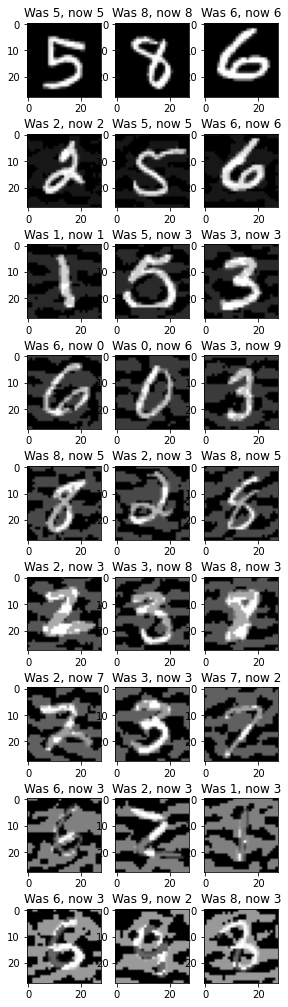

In [12]:
# Print 3 random images for each epsilon value to see differences
# Subplot(r,c) provide the number of rows and columns
number_rows = len(epsilons)
number_columns = 3
_, axarr = plt.subplots(
    number_rows, number_columns, figsize=(1.5 * number_columns, 2 * number_rows)
)

# Select the images and show the noise
for r, epsilon in zip(range(number_rows), epsilons):
    for c in range(number_columns):
        plot = axarr[r, c]

        # Get random image index
        index = np.random.randint(0, len(testSetLoader.dataset))

        # Get an image and cast it to CUDA if needed, cast to proper batches
        image, label = testSetLoader.dataset[index]
        image = image[None, :]
        label = torch.as_tensor((label,))

        image, label = image.to(device), label.to(device)

        # Set requires_grad attribute of tensor, basically remembers gradients
        image.requires_grad = True

        # This essentially makes sure we retain the gradients
        image.retain_grad()

        # Predict
        logits = model(image)
        _, pred = torch.max(logits, 1)

        # Calculate the loss
        loss = loss_function(logits, label)

        # No training should be done here, so set the optimizer gradients to zero
        optimizer.zero_grad()

        # backpropagation, compute gradients
        loss.backward()

        # Collect datagrad
        data_grad = image.grad.data

        # Call FGSM Attack
        perturbed_image = fgsm.fgsm_attack(image, epsilon, data_grad)

        # Calculate results
        logits = model(perturbed_image)
        _, fgsm_pred = torch.max(logits, 1)

        pred = pred.cpu().detach()[0]
        fgsm_pred = fgsm_pred.cpu().detach()[0]
        plot.set_title(f"Was {pred}, now {fgsm_pred}")
        plot.imshow(perturbed_image.cpu().detach()[0][0], cmap=plt.get_cmap("gray"))

In [13]:
# Run test for each epsilon
for epsilon in epsilons:
    fgsm_attack_trained_model(model, loss_function, optimizer, epsilon=epsilon)

Testing the model using FGSM with epsilon = 0...


FGSM Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.09%


Testing the model using FGSM with epsilon = 0.05...


FGSM Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 91.85%


Testing the model using FGSM with epsilon = 0.1...


FGSM Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 64.66%


Testing the model using FGSM with epsilon = 0.15...


FGSM Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 34.34%


Testing the model using FGSM with epsilon = 0.2...


FGSM Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 19.51%


Testing the model using FGSM with epsilon = 0.25...


FGSM Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 12.06%


Testing the model using FGSM with epsilon = 0.3...


FGSM Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 8.67%


Testing the model using FGSM with epsilon = 0.5...


FGSM Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 4.13%


Testing the model using FGSM with epsilon = 0.75...


FGSM Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 3.63%




## Attacks moving forward use a single function (and take in as argument a different attack)

In [14]:
def attack_trained_model(model, loss_function, attack, epsilon, alpha):
    # Network parameters
    loss_function = nn.CrossEntropyLoss()

    correct = 0

    print("Testing the model using epsilon = {}, alpha = {}...".format(epsilon, alpha))

    # Use a pretty progress bar to show updates
    for j, (images, labels) in enumerate(
        tqdm(testSetLoader, desc="Attack Testing Progress")
    ):
        # Cast to proper tensor
        images, labels = images.to(device), labels.to(device)

        # Perturb the images using the I-FGSM attack
        perturbed_images = attack(
            images,
            labels,
            model,
            loss_function,
            epsilon=epsilon,
            alpha=alpha,
            scale=True,
        )

        # Calculate results
        logits = model(perturbed_images)

        _, preds = torch.max(logits, 1)

        correct += (preds == labels).sum().item()

    print("... done! Accuracy: {}%\n\n".format(float(correct) * 100 / 10000))

In [15]:
def print_perturbed_images(model, loss_function, attack, epsilons, alpha):
    # Print 3 random images for each epsilon value to see differences
    # Subplot(r,c) provide the number of rows and columns
    number_rows = len(epsilons)
    number_columns = 3
    _, axarr = plt.subplots(
        number_rows, number_columns, figsize=(1.5 * number_columns, 2 * number_rows)
    )

    # Select the images and show the noise
    for r, epsilon in zip(range(number_rows), epsilons):
        for c in range(number_columns):
            plot = axarr[r, c]

            # Get random image index
            index = np.random.randint(0, len(testSetLoader.dataset))

            # Get an image and cast it to CUDA if needed, cast to proper batches
            image, label = testSetLoader.dataset[index]
            image = image[None, :]
            label = torch.as_tensor((label,))

            image, label = image.to(device), label.to(device)

            # Predict
            logits = model(image)
            _, pred = torch.max(logits, 1)

            # Call the attack
            perturbed_image = attack(
                image,
                label,
                model,
                loss_function,
                epsilon=epsilon,
                alpha=alpha,
                scale=True,
            )

            # Calculate results
            logits = model(perturbed_image)
            _, fgsm_pred = torch.max(logits, 1)

            pred = pred.cpu().detach()[0]
            fgsm_pred = fgsm_pred.cpu().detach()[0]
            plot.set_title(f"Was {pred}, now {fgsm_pred}")
            plot.imshow(perturbed_image.cpu().detach()[0][0], cmap=plt.get_cmap("gray"))

### I-FGSM / BIM (Iterative FGSM / Basic Iterative Method) https://arxiv.org/abs/1607.02533

The formula that is used for producing the adversarial example in this case is:

$x'_{0} = x$
$x'_{k + 1} = Clip_{x, \epsilon} \{x'_{k} + \alpha * sign(\nabla_{x}J(\theta, x'_{k}, y)\}$, where J is the loss function used. Note that in the paper proposing this method, $\alpha = 1$ is used, so pixels are changed by 1 in each iteration.

The formula for the clip function is also given in the paper.

In [16]:
import attacks.ifgsm as ifgsm

In [17]:
# Several values for epsilon. It's interesting to see how clamping affects results
epsilons = [0.25, 0.5, 0.75, 1, 2, 3, 4]

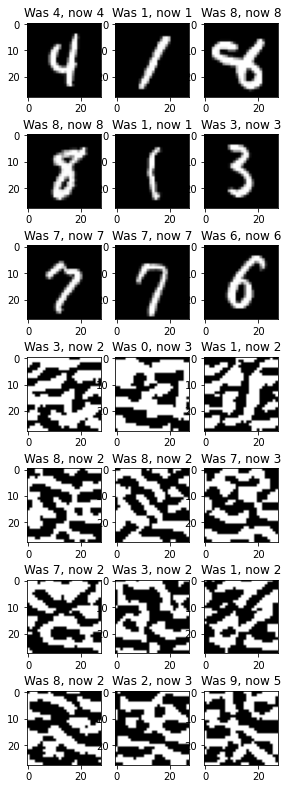

In [18]:
print_perturbed_images(model, loss_function, ifgsm.ifgsm_attack, epsilons, alpha=1)

In [19]:
for epsilon in epsilons:
    attack_trained_model(
        model, loss_function, ifgsm.ifgsm_attack, epsilon=epsilon, alpha=1
    )

Testing the model using epsilon = 0.25, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.09%


Testing the model using epsilon = 0.5, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.09%


Testing the model using epsilon = 0.75, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.09%


Testing the model using epsilon = 1, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 8.86%


Testing the model using epsilon = 2, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.63%


Testing the model using epsilon = 3, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.21%


Testing the model using epsilon = 4, alpha = 1...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.01%




### PGD (Projected Gradient Descent) https://arxiv.org/pdf/1706.06083.pdf

The formula that is used for producing the adversarial example in this case is:

$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$\n
where S is a set of allowed perturbations. Note that this is basically BIM with random initialisation. 

We use the $L_{\infty}$ norm here, i.e. we use clamping. 

In [20]:
import attacks.pgd as pgd

In [24]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.15, 0.3, 1, 2, 3, 4]

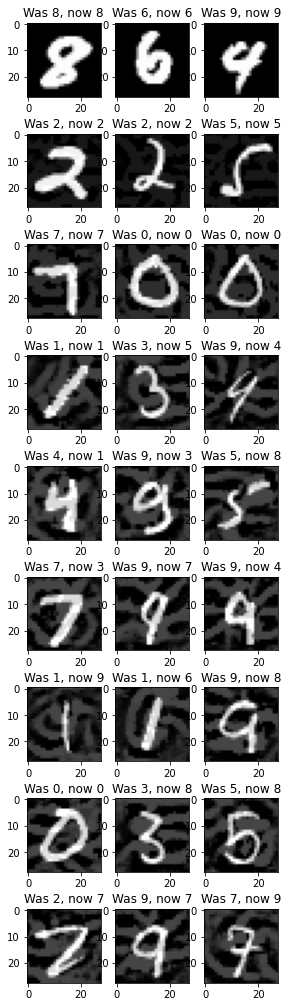

In [25]:
print_perturbed_images(
    model, loss_function, pgd.pgd_attack, epsilons, alpha=(2 / 255)
)

In [26]:
for epsilon in epsilons:
    attack_trained_model(
        model, loss_function, pgd.pgd_attack, epsilon=epsilon, alpha=(2 / 255)
    )

Testing the model using epsilon = 0, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.09%


Testing the model using epsilon = 0.05, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 90.44%


Testing the model using epsilon = 0.1, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 50.75%


Testing the model using epsilon = 0.15, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 15.42%


Testing the model using epsilon = 0.3, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 13.39%


Testing the model using epsilon = 1, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 13.39%


Testing the model using epsilon = 2, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 13.39%


Testing the model using epsilon = 3, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 13.39%


Testing the model using epsilon = 4, alpha = 0.00784313725490196...


Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 13.39%


